In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.pinopi as pnp
import analysis.plotting as plotting

In [5]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
# general_vals_dict['TWPA_freq'] = 8.6
# general_vals_dict['TWPA_pwr'] = 1.4
print(f"{q1}\n{q2}")

Qubit(ro_freq=6.72745, ROIF=0.10275000000000034, RO_LO=6.6247, RO_IF=None, ef_amp=0.5, IQ_angle=205, ef_ssm=-0.259, ro_dur=4000, ef_time=74.1982640369346, ge_time=67.19789394714729, ge_ssm=-0.114, ro_amp=1, qubit_id=q1, qubit_thr=[-10000, -600], ge_amp=0.5, RO_LO_pwr=16)
Qubit(ro_freq=6.6556, ROIF=0.030899999999999928, RO_LO=6.6247, RO_IF=None, ef_amp=1, IQ_angle=85, ef_ssm=-0.224, ro_dur=4000, ef_time=None, ge_time=45.047198597262124, ge_ssm=-0.154, ro_amp=1.5, qubit_id=q2, qubit_thr=[-10000, 1900], ge_amp=0.5, RO_LO_pwr=16)


In [12]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
num_steps = 3
reps = 10000
swap_freq= -.0192
swap_time=0.5*7/abs(swap_freq)#193.5253031907684
# q1.ge_amp = 0.4
# q1.ge_time =  81.30534179581487
# q1.ef_time =  46.46542951915684
# q1.ef_amp = 0.8
swap_time

182.29166666666669

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 10000
Buffers per acquistion: 10
DAQ samples per pattern: 8192
0, No error
Capturing 10 buffers. Press <enter> to abort
Capture completed in 4.234712 sec
Captured 10 buffers (2.361436 buffers per sec)
Captured 30720 records (7254.330189 records per sec)
Transferred 503316480 bytes (118854945.809145 bytes per sec)


<Figure size 800x800 with 0 Axes>

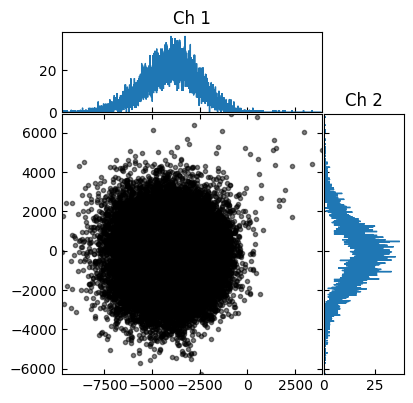

<Figure size 800x800 with 0 Axes>

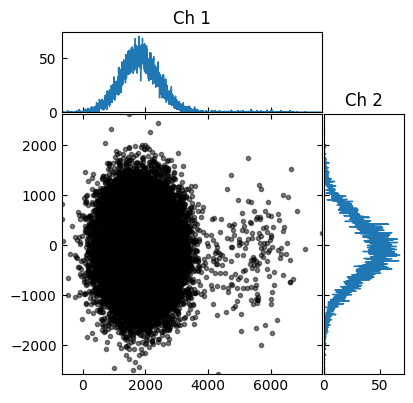

saved G
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 10000
Buffers per acquistion: 10
DAQ samples per pattern: 8192
0, No error
Capturing 10 buffers. Press <enter> to abort
Capture completed in 4.025914 sec
Captured 10 buffers (2.483908 buffers per sec)
Captured 30720 records (7630.565018 records per sec)
Transferred 503316480 bytes (125019177.253004 bytes per sec)


<Figure size 800x800 with 0 Axes>

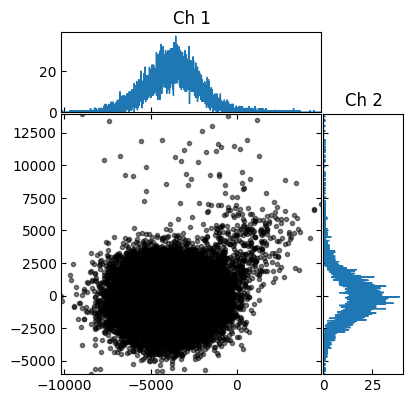

<Figure size 800x800 with 0 Axes>

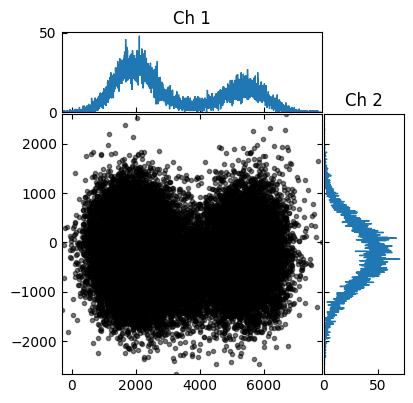

saved E
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 10000
Buffers per acquistion: 10
DAQ samples per pattern: 8192
0, No error
Capturing 10 buffers. Press <enter> to abort
Capture completed in 7.727112 sec
Captured 10 buffers (1.294145 buffers per sec)
Captured 30720 records (3975.611954 records per sec)
Transferred 503316480 bytes (65136426.248147 bytes per sec)


<Figure size 800x800 with 0 Axes>

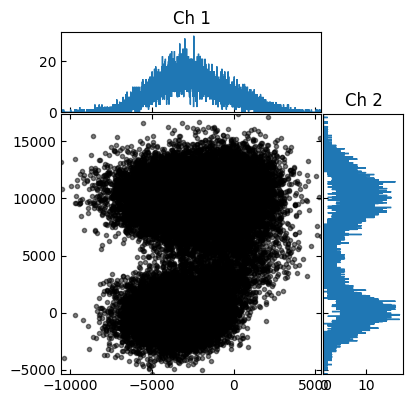

<Figure size 800x800 with 0 Axes>

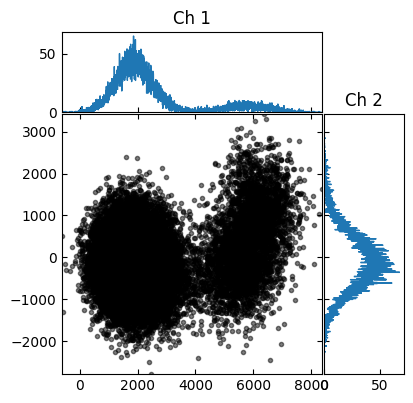

saved F


In [11]:
phase = 350
for i in range(3):
    if 0 == i:
        label = 'G'
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 1,copige = 0,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase)
    elif 1 == i:
        label = 'E'
        # E prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 1,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase)
    elif 2 == i:
        label = 'F'
        # F prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 1, coswap = 1,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time,phase=phase)

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    values = daq.run_daq_het_2q(q1, q2,
                    num_patterns=num_steps, num_records_per_pattern=reps,
                        verbose=True)

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0][0:reps*num_steps]
    Q1_raw = values.rec_readout_1[1][0:reps*num_steps]
    I2_raw = values.rec_readout_2[0][0:reps*num_steps]
    Q2_raw = values.rec_readout_2[1][0:reps*num_steps]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    if 0 == i:
        g_IQ = IQ_df
    elif 1 == i:
        e_IQ = IQ_df
    else:
        f_IQ = IQ_df
    IQ_df.to_csv(f'IQraw{label}.csv')
    print(f"saved {label}")

In [ ]:
g_IQ['label'] = [0 for _ in range(len(g_IQ))]
e_IQ['label'] = [1 for _ in range(len(e_IQ))]
f_IQ['label'] = [2 for _ in range(len(f_IQ))]

three_state = pd.concat([g_IQ, e_IQ, f_IQ ], axis = 0)
try:
    three_state = three_state.drop(columns="Unnamed: 0")
except:
    pass
three_state = three_state.sample(frac=1).reset_index(drop=True)
three_state.head()

,I1,Q1,I2,Q2,label
0,-302.678672,-910.651256,1864.309607,-805.501887,2
1,-1240.688673,8766.777906,2053.692600,-807.104474,2
2,-1245.744010,-226.271207,2312.067056,-827.634898,0
3,-2522.111229,-1294.562518,2102.298810,1311.036565,0
4,-1590.399523,500.072835,1621.461582,22.038774,2


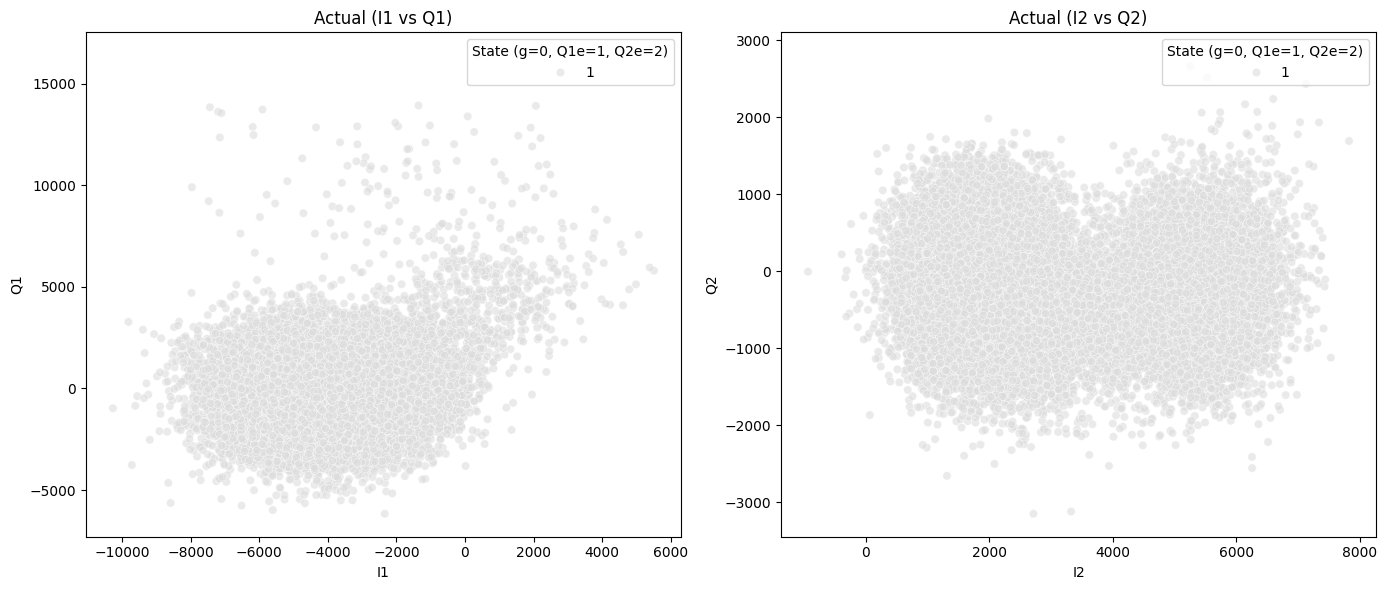

In [ ]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sliced_data = three_state [three_state['label'] == 1]
# First subplot: I1 vs Q1
sns.scatterplot(
    data=sliced_data,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=sliced_data,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()